In [46]:
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import numpy as np 
import pandas as pd
import seaborn as sns
import gensim
import re, string, unicodedata
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, SpatialDropout1D
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.preprocessing.text import Tokenizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
#loading data from google drive
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#train_file_id = '15NNft0C1CKlKDzjUKbAgibbXTFe8NFgG'
test_file_id = '1J4K-z82tEr4jkwG1Hl1t-eigpcivqt3k' 
'''
download = drive.CreateFile({'id': train_file_id})
download.GetContentFile('train.csv')
train_data  = pd.read_csv("train.csv")
train_data.head()
'''
url = "https://raw.githubusercontent.com/EducationalTestingService/sarcasm/master/twitter/sarcasm_detection_shared_task_twitter_training.jsonl"
url2 ='https://raw.githubusercontent.com/wjq-learning/MSTI/main/datasets/Textual%20target%20labels/train'
df = pd.read_json(url, lines=True)
print(df.head())
     

     label                                           response  \
0  SARCASM  @USER @USER @USER I don't get this .. obviousl...   
1  SARCASM  @USER @USER trying to protest about . Talking ...   
2  SARCASM  @USER @USER @USER He makes an insane about of ...   
3  SARCASM  @USER @USER Meanwhile Trump won't even release...   
4  SARCASM  @USER @USER Pretty Sure the Anti-Lincoln Crowd...   

                                             context  
0  [A minor child deserves privacy and should be ...  
1  [@USER @USER Why is he a loser ? He's just a P...  
2  [Donald J . Trump is guilty as charged . The e...  
3  [Jamie Raskin tanked Doug Collins . Collins lo...  
4  [Man ... y ’ all gone “ both sides ” the apoca...  


In [48]:
df.isna().sum() # Checking for NaN values

label       0
response    0
context     0
dtype: int64

In [49]:
df.head()

,label,response,context
0,SARCASM,@USER @USER @USER I don't get this .. obviousl...,[A minor child deserves privacy and should be ...
1,SARCASM,@USER @USER trying to protest about . Talking ...,[@USER @USER Why is he a loser ? He's just a P...
2,SARCASM,@USER @USER @USER He makes an insane about of ...,[Donald J . Trump is guilty as charged . The e...
3,SARCASM,@USER @USER Meanwhile Trump won't even release...,[Jamie Raskin tanked Doug Collins . Collins lo...
4,SARCASM,@USER @USER Pretty Sure the Anti-Lincoln Crowd...,[Man ... y ’ all gone “ both sides ” the apoca...


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


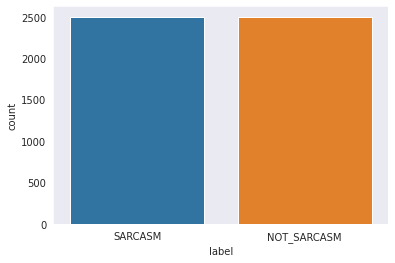

In [50]:
sns.set_style("dark")
sns.countplot(df.label)

In [52]:
for idx,row in df.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
df2 = df['response'].copy()
#df2['context'] = df['context'].copy()
tokenizer.fit_on_texts(df2.values)
X = tokenizer.texts_to_sequences(df2.values)
X = pad_sequences(X)

In [53]:
label_mapping = {'SARCASM': 1, 'NOT_SARCASM': 0}
df['label'] = df['label'].map(label_mapping)

In [60]:
Y = pd.get_dummies(df['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3350, 61) (3350, 2)
(1650, 61) (1650, 2)


In [61]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['acc'])

In [62]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 61, 128)           256000    
                                                                 
 spatial_dropout1d_5 (Spatia  (None, 61, 128)          0         
 lDropout1D)                                                     
                                                                 
 lstm_5 (LSTM)               (None, 196)               254800    
                                                                 
 dense_5 (Dense)             (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________


In [63]:
batch_size = 128
history = model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, validation_data = (X_test,Y_test), verbose = 2)

Epoch 1/20
27/27 - 11s - loss: 0.6703 - acc: 0.6236 - val_loss: 0.5508 - val_acc: 0.7279 - 11s/epoch - 424ms/step
Epoch 2/20
27/27 - 9s - loss: 0.4624 - acc: 0.7791 - val_loss: 0.5571 - val_acc: 0.7170 - 9s/epoch - 318ms/step
Epoch 3/20
27/27 - 12s - loss: 0.3418 - acc: 0.8522 - val_loss: 0.6205 - val_acc: 0.7048 - 12s/epoch - 452ms/step
Epoch 4/20
27/27 - 13s - loss: 0.2582 - acc: 0.9009 - val_loss: 0.7620 - val_acc: 0.7200 - 13s/epoch - 470ms/step
Epoch 5/20
27/27 - 8s - loss: 0.1765 - acc: 0.9328 - val_loss: 0.9170 - val_acc: 0.7067 - 8s/epoch - 283ms/step
Epoch 6/20
27/27 - 8s - loss: 0.1546 - acc: 0.9391 - val_loss: 1.0020 - val_acc: 0.7133 - 8s/epoch - 283ms/step
Epoch 7/20
27/27 - 8s - loss: 0.1027 - acc: 0.9600 - val_loss: 1.0472 - val_acc: 0.6927 - 8s/epoch - 283ms/step
Epoch 8/20
27/27 - 8s - loss: 0.0858 - acc: 0.9678 - val_loss: 1.1336 - val_acc: 0.7055 - 8s/epoch - 283ms/step
Epoch 9/20
27/27 - 8s - loss: 0.0655 - acc: 0.9788 - val_loss: 1.3971 - val_acc: 0.7036 - 8s/epoch

In [64]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,Y_train)[1]*100)
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,Y_test)[1]*100)

105/105 [==============================] - 2s 18ms/step - loss: 0.0057 - acc: 0.9982
Accuracy of the model on Training Data is -  99.82089400291443
52/52 [==============================] - 2s 32ms/step - loss: 1.6051 - acc: 0.6842
Accuracy of the model on Testing Data is -  68.42424273490906


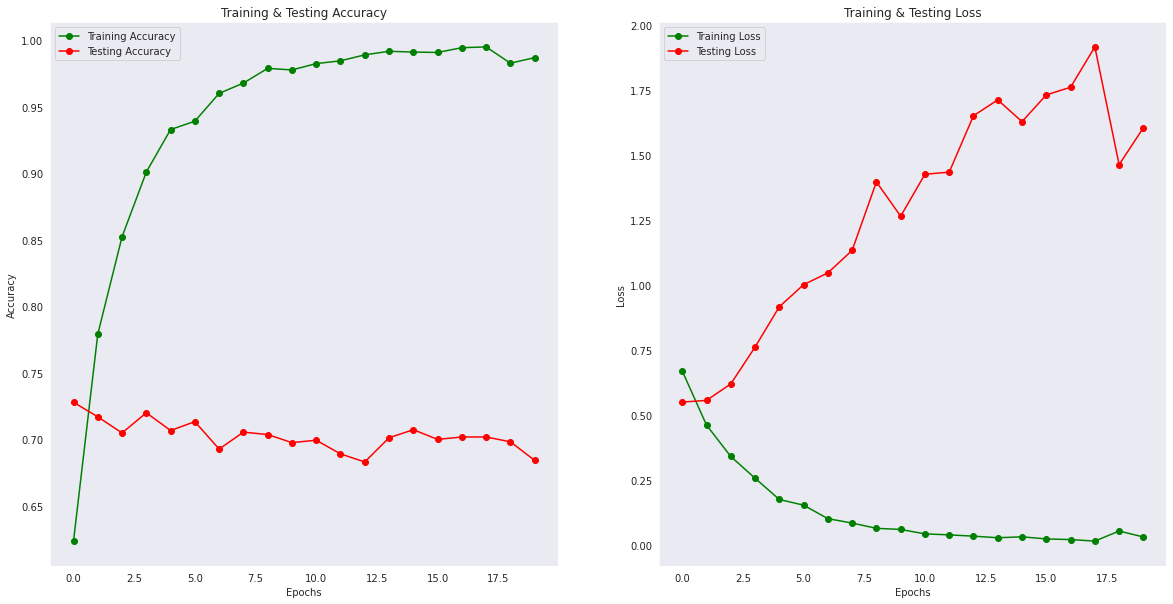

In [65]:
epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [92]:
y_test = []
for i in range(len(Y_test)):
    y_test.append(Y_test[i][0])

len(y_test)

1650

In [94]:
y_proba = model.predict_on_batch(X_test)
y_pred = y_proba.argmax(axis=-1)

In [95]:
cm = confusion_matrix(y_test,y_pred)
cm

array([[269, 581],
       [548, 252]])

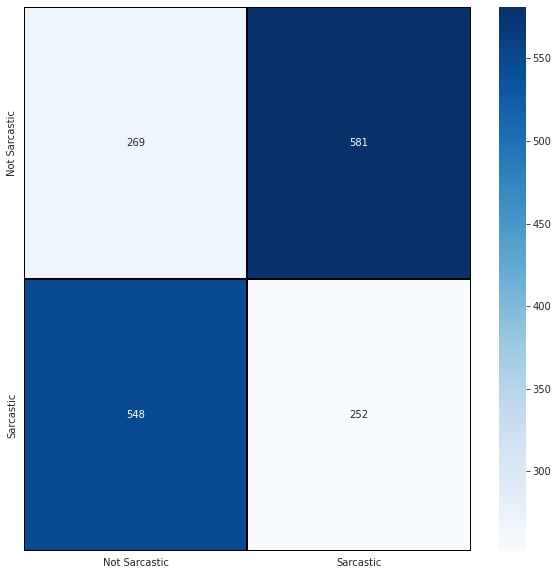

In [96]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])